# Gradient computations with mixed computational graphs

## Author: M. Ravasi

This notebook compares various apporaches to compute the FWI gradient with respect to input parameters that are the weights/biases of a NN (in Torch):

- Create overall computational graph by embedding the FWI waveengine into a TorchOperator and let Torch do the differentiation for us;
- Decouple the gradient computation in two parts, one tasked with a torch graph (e.g., neural network parametrizing the velocity model) and one with the devito propagator. This way we can potentially optimize the latter computation (potentially distributing it over multiple workers) whilst letting torch deal with the first part for us.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import copy
import numpy as np
import matplotlib.pyplot as plt
import torch

from functools import partial
from scipy.ndimage import gaussian_filter
from pylops.basicoperators import Identity

from functools import partial
from devito import configuration
from tqdm.notebook import tqdm

from devitofwi.devito.utils import clear_devito_cache
from devitofwi.deep.torchoperator import TorchOperator
from devitofwi.deep.utils import set_seed
from devitofwi.deep.unet2d import ResUNet
from devitofwi.waveengine.acoustic import AcousticWave2D
from devitofwi.loss.l2 import L2
from devitofwi.postproc.acoustic import create_mask, PostProcessVP

configuration['log-level'] = 'ERROR'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
clear_devito_cache()

## Parameters 

In [4]:
# Model and aquisition parameters
par = {'nx':512,   'dx':15,    'ox':0,
       'nz':220,   'dz':15,    'oz':0,
       'ns':20,    'ds':300,   'os':800,  'sz':0,
       'nr':255,   'dr':30,    'or':0,     'rz':0,
       'nt':3000,  'dt':0.002, 'ot':0,
       'freq':15,
      }

# Modelling parameters
shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
space_order = 4
nbl = 20

# Velocity model
path = '../../data/'
velocity_file = path + 'Marm.bin'

## Acquisition set-up

In [5]:
# Sampling frequency
fs = 1 / par['dt'] 

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1] * 1e3 # in ms

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz']

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz']

## Velocity model

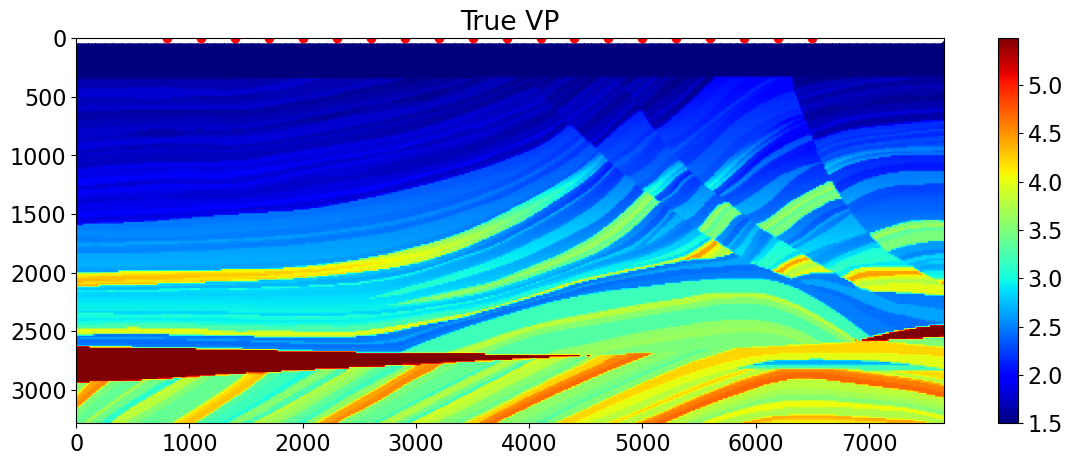

In [6]:
# Load the true model
vp_true = np.fromfile(velocity_file, np.float32).reshape(221, 601)[:par['nz'], :par['nx']].T
msk = create_mask(vp_true, 1.52) # get the mask for the water layer 

m_vmin, m_vmax = np.percentile(vp_true, [2,98]) 

plt.figure(figsize=(14, 5))
plt.imshow(vp_true.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('True VP')
plt.axis('tight');

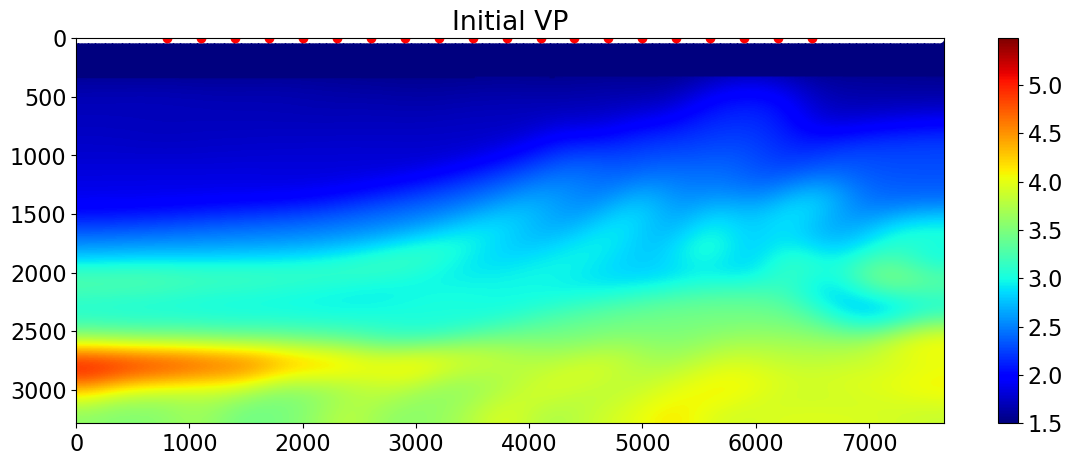

In [7]:
# Initial model for FWI by smoothing the true model
vp_init = gaussian_filter(vp_true, sigma=[15,10])
vp_init = vp_init * msk  # to preserve the water layer  
vp_init[vp_init == 0] = 1.5

plt.figure(figsize=(14, 5))
plt.imshow(vp_init.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Initial VP')
plt.axis('tight');

## Data modelling

In [8]:
amod = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,
                      vp=vp_true * 1e3, 
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl)

In [9]:
# Model data
dobs = amod.mod_allshots()

  0%|          | 0/20 [00:00<?, ?it/s]

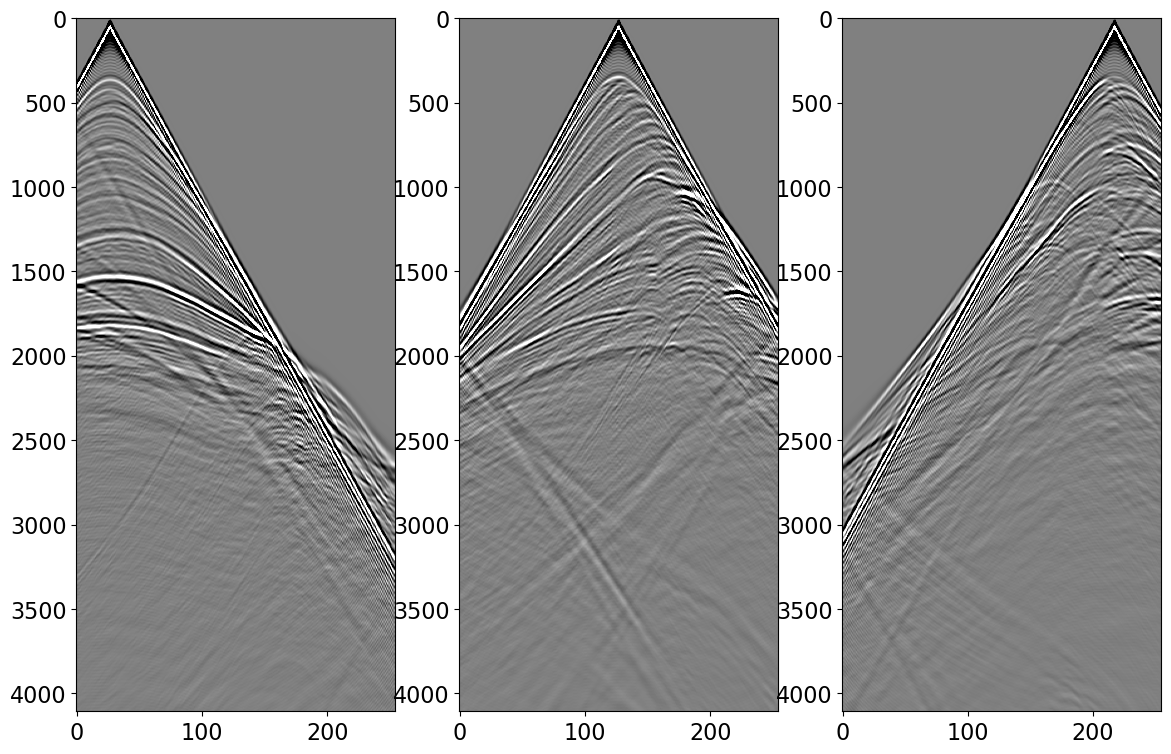

In [10]:
# Plot shot gathers
d_vmin, d_vmax = np.percentile(np.hstack(dobs).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)

## Compare coupled with decoupled gradients

In [11]:
# Define A Neural Network used to parametrize the velocity model
network = ResUNet(1, 1, hidden_channels=64, levels=2, subsampling=[[2,  2], [2, 2]])
network = network.apply(network.weights_init)

network_decoupled = copy.deepcopy(network)

# Check network and network_decoupled have same parameters
#for n, nd in zip(network.parameters(), network_decoupled.parameters()):
#    print(torch.sum(n-nd))

In [12]:
# Define loss as simple unweighted L2 difference of observed and modelled data
l2loss = L2(Identity(int(np.prod(dobs.shape[1:]))), dobs.reshape(par['ns'], -1))

ainv = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,
                      vprange=(vp_true.min() * 1e3, vp_true.max() * 1e3),
                      vpinit=vp_init * 1e3,
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl,
                      loss=l2loss)
postproc = PostProcessVP(scaling=1, mask=msk)

  0%|          | 0/20 [00:00<?, ?it/s]

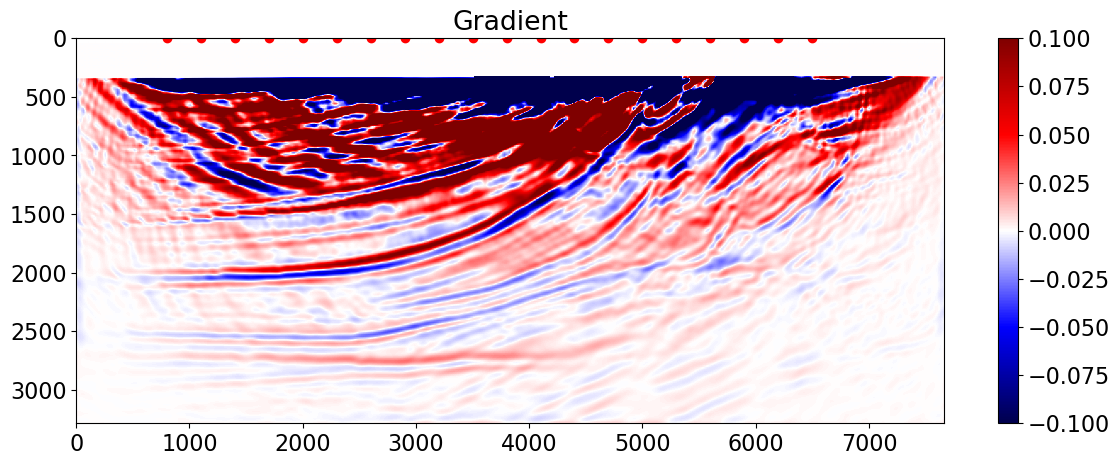

In [13]:
# Compute first gradient and find scaling with Torch
postproc = PostProcessVP(scaling=1, mask=msk)
ainv_torch = TorchOperator(ainv.loss_grad, kwargs_prop=dict(postprocess=postproc.apply))

vp_init_torch = torch.from_numpy(vp_init)
vp_init_torch.requires_grad = True
loss_torch = ainv_torch.apply(vp_init_torch)
loss_torch.backward()
direction = vp_init_torch.grad.numpy()

scaling = direction.max()

plt.figure(figsize=(14, 5))
plt.imshow(direction.T / scaling, cmap='seismic', vmin=-1e-1, vmax=1e-1, 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Gradient')
plt.axis('tight');

In [14]:
# Create noise vectors
noise_torch = torch.randn(par['nx'], par['nz']).float()
noise_torch_decoupled = noise_torch.clone()

# noise_torch_decoupled - noise_torch

In [15]:
# Torch autograd gradient
network.zero_grad()

postproc = PostProcessVP(scaling=scaling, mask=msk)
ainv_torch = TorchOperator(ainv.loss_grad, kwargs_prop=dict(postprocess=postproc.apply))

# Compute model
vp_inv_torch = network(noise_torch.unsqueeze(0).unsqueeze(0)).squeeze()

# Compute FWI gradient all the way to network internal parameters
loss = ainv_torch.apply(vp_inv_torch)
loss.backward()

  0%|          | 0/20 [00:00<?, ?it/s]

In [16]:
# Decoupled gradient
network_decoupled.zero_grad()

# Compute model
vp_inv_torch_decoupled = network_decoupled(noise_torch_decoupled.unsqueeze(0).unsqueeze(0)).squeeze()
print('Vp_inv difference', torch.sum((vp_inv_torch_decoupled - vp_inv_torch) ** 2) / torch.sum(vp_inv_torch ** 2))

# Compute FWI gradient
loss, direction = ainv.loss_grad(vp_inv_torch_decoupled.clone().detach().numpy(), postprocess=postproc.apply)

# Compute network gradients
grads = torch.autograd.grad(vp_inv_torch_decoupled, network_decoupled.parameters(), 
                            grad_outputs=torch.from_numpy(np.array(direction).reshape(par['nx'], par['nz'])))

# Update gradient of network internal parameters
for param, gr in zip(network_decoupled.named_parameters(), grads):
    param[1].grad = gr

# At this point, if you have passed network_decoupled to an optimizer, can run optimizer.step()

Vp_inv difference tensor(0., grad_fn=<DivBackward0>)


  0%|          | 0/20 [00:00<?, ?it/s]

In [17]:
# Check network and network_decoupled have same gradients
for n, nd in zip(network.parameters(), network_decoupled.parameters()):
    assert np.allclose(torch.sum(n.grad - nd.grad).numpy(), 0.)